# Main Quest 03 - CNN
## 2. 가위바위보 분류기

In [1]:
# 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


### 데이터 만들기
- 구글 [teachable machine](https://teachablemachine.withgoogle.com/) 사이트 활용
- lms 디렉토리에 업로드
    - `mkdir -p` 명령어 사용 : 하위디렉토리 생성할때 자동으로 중간 단계 디렉토리 생성하는 명령어
- cloud 압축해제
    - 압축 해제 명령어 : unzip <파일명>.zip
        
        `cd  ~/aiffel/rock_scissor_paper/rock`
        `unzip rock.zip`

        `cd  ~/aiffel/rock_scissor_paper/scissor`
        `unzip scissor.zip`

        `cd  ~/aiffel/rock_scissor_paper/paper`
        `unzip paper.zip`

### 데이터 불러오기
- 내 데이터

In [2]:
# 필요 라이브러리 불러오기
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


#### 데이터 전처리 - 사진 사이즈 조정
- 원본 사이즈는 224x224
- 28x28 사이즈로 조정한다

In [3]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        # 데이터 shape 확인
#         print("original image shape:",old_img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")
    
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [4]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [5]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 이미지 resize 완료!


#### load_data()
- 임의의 함수를 만들어서 전체 데이터를 학습할수 있는 데이터로 변경한다

In [6]:
# 데이터 불러오기
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


- ~내 가위바위보 사진 데이터의 총 개수가 300이 넘기 때문에 에러발생~
- ~추후에 추가 이미지를 사용하는것으로 하고,~ 일단 300으로 맞춰서 이미지를 삭제한 후 코드 다시 실행

라벨:  0


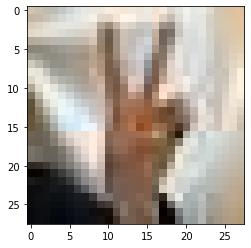

In [7]:
# 이미지 확인
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

- 와 엄청나게 화질이 좋지 않다...! 
- 이걸 제대로 학습할지 의문인데...! 피처를 잘 뽑아내도록 convolution layer를 만들어봐야겠다
- 그리고 일단 이 라벨은 0으로 나오는데, 가위가 0인건가..?
    - 다른 이미지도 출력해본다

라벨:  1


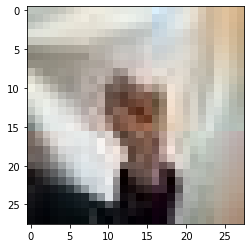

In [8]:
# 추가 이미지 출력 - 주먹 라벨 확인
plt.imshow(x_train[187])
print('라벨: ', y_train[187])

라벨:  2


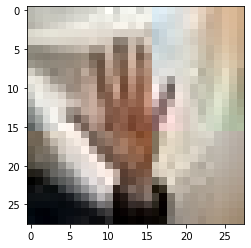

In [9]:
# 추가 이미지 출력 - 보자기 라벨 확인
plt.imshow(x_train[237])
print('라벨: ', y_train[237])

#### 👉정리해보면
- 정답 라벨
    - 가위 : 0
    - 주먹 : 1
    - 보자기 : 2

## 모델 설계
- MNIST CNN 구조를 참고해서 큰 윤곽을 그려보고, 가위바위보에 데이터에 좀더 맞는 추가 작업을 해보려고한다

### 데이터 파악
- 컬러이미지
- 구분해야하는 클래스 개수 : 3개

### MNIST 데이터와 비교
- MNIST 데이터는 숫자와 숫자가 아닌 부분이 매우 뚜렷하게 구분되서 이미지 특징을 뽑아내는게 좋을것같지만
    - 내 사진은 윤곽을 제대로 찾아내는게 쉽지않을것 같다..
- 데이터양 차이가 크다. 
    - 먼저 모델학습을 진행해보고 결과가 좋지않다면 추가 이미지 생성을 해봐야겠다

In [10]:
# 필요 라이브러리 로드
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [11]:
# model
'''
convolution layer 
- kernel_size : 3,3

maxpooling
- kernel_size : 2,2

activation function : relu
final activation function : softmax
optimizer : adam
loss : 교차 엔트로피오차 함수
'''
model = keras.models.Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3))) # image feature
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu')) # image feature
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu')) # 분류기 알고리즘 복잡도
model.add(Dense(3, activation='softmax')) # 최종 분류기 class 수


In [12]:
# model check
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [13]:
# model layer 개수 확인
print(len(model.layers))

7


In [14]:
# model training
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=20, validation_split=0.25)

Epoch 1/20
8/8 [==============================] - 1s 47ms/step - loss: 1.0398 - accuracy: 0.3956 - val_loss: 2.4123 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 0s 22ms/step - loss: 0.9239 - accuracy: 0.4889 - val_loss: 2.1854 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 0s 24ms/step - loss: 0.8698 - accuracy: 0.5956 - val_loss: 2.0930 - val_accuracy: 0.0000e+00
Epoch 4/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8543 - accuracy: 0.8533 - val_loss: 1.4736 - val_accuracy: 0.0000e+00
Epoch 5/20
8/8 [==============================] - 0s 23ms/step - loss: 0.8000 - accuracy: 0.8400 - val_loss: 2.1178 - val_accuracy: 0.0000e+00
Epoch 6/20
8/8 [==============================] - 0s 22ms/step - loss: 0.7321 - accuracy: 0.7822 - val_loss: 2.3165 - val_accuracy: 0.0000e+00
Epoch 7/20
8/8 [==============================] - 0s 24ms/step - loss: 0.6424 - accuracy: 0.8622 - val_loss: 2.0754 - val_accuracy: 0.0000e+00

- 데이터양이 너무 적어서 그런지 검증데이터의 정확도가 매우 낮다.
- 일단 정확도 테스트를 해본다

## 정확도 테스트
1) 승순님 데이터로 테스트 데이터셋 변환

In [15]:
# resizing data
# 승순님 데이터
image_dir_path_s = os.getenv("HOME") + "/aiffel/ss_data/scissor"
image_dir_path_r = os.getenv("HOME") + "/aiffel/ss_data/rock"
image_dir_path_p = os.getenv("HOME") + "/aiffel/ss_data/paper"
resize_images(image_dir_path_s)
resize_images(image_dir_path_r)
resize_images(image_dir_path_p)

# split data to test
image_dir_path = os.getenv("HOME") + "/aiffel/ss_data"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [16]:
# test accuracy 측정
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.2462 - accuracy: 0.8800
test_loss: 0.24615603685379028 
test_accuracy: 0.8799999952316284


- 87%의 정확도가 출력된다.
- 제대로 라벨링한게 맞는지 출력해서 확인해봐야겠다

In [17]:
# model.predict() 확인
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=110  #110번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [1.7270086e-04 9.9704260e-01 2.7847120e-03]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


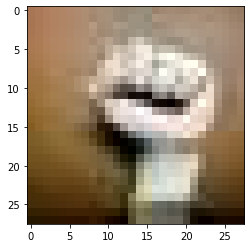

In [18]:
# 실제 정답과 확인
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

- 오.. 맞았다!
- 승환님 데이터셋으로 2차 정확도 테스트!
---
2) 승환님 데이터로 테스트 데이터셋 변환

In [19]:
# resizing data
# 승환님 데이터
image_dir_path_s = os.getenv("HOME") + "/aiffel/sh_data/scissor"
image_dir_path_r = os.getenv("HOME") + "/aiffel/sh_data/rock"
image_dir_path_p = os.getenv("HOME") + "/aiffel/sh_data/paper"
resize_images(image_dir_path_s)
resize_images(image_dir_path_r)
resize_images(image_dir_path_p)

# split data to test
image_dir_path = os.getenv("HOME") + "/aiffel/sh_data"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [20]:
# test accuracy 측정
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.2462 - accuracy: 0.8800
test_loss: 0.24615603685379028 
test_accuracy: 0.8799999952316284


In [21]:
# model.predict() 확인
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=230  #230번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.7330362  0.02612481 0.24083894]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  2


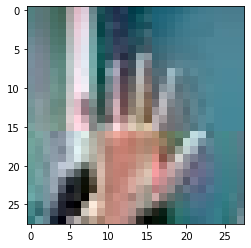

In [22]:
# 실제 정답과 확인
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

- 사실 처음 코드를 서서 작성할때엔 정확도가 1이 나와서 오버피팅이 되는게 아닌가 싶었는데 새로운 테스트 데이터셋에도 정확도가 1이 출력되었다.
- 커널을 재시작후 다시 새로 모델학습을 시켜보니 정확도가 88% 정도가 나와서 이전에는 무언가 잘못되었던게 맞는것 같다.
- 하지만 왠지 데이터셋 순서를 익혀서 맞추는게 아닐까 하는 의심이 들기 시작했다. 이미지들이 가위, 바위, 보 순서대로 인덱싱 되어있는것 같았기 때문이다. 
    - 데이터 셋을 무작위로 섞어서 다시 테스트를 해보기로 결정!

---
## 데이터셋 순서 변경후 모델 학습

### 이미지 데이터 시각화해서 확인

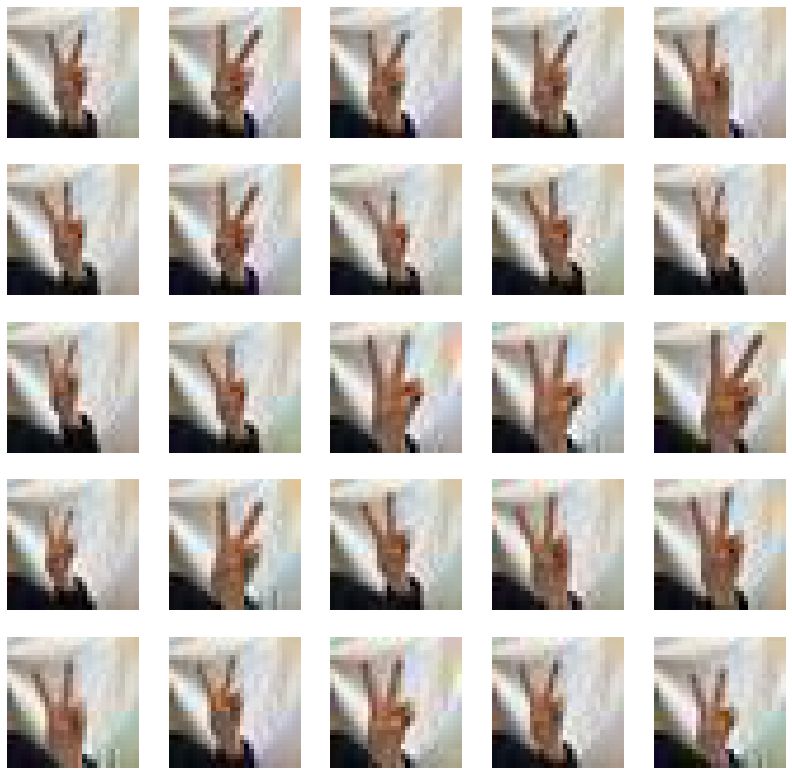

In [23]:
plt.figure(figsize=(14, 14))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.imshow(x_train[i], 'gray')
    plt.axis('off')
plt.show()

- 역시 가위, 바위, 보 순으로 데이터들이 저장되어있다.
- MNIST에서는 인덱스 값 순서대로 0-9가 분류되어있지 않았기때문에 내 데이터셋의 순서도 변경이 필요하다

### 새로운 데이터셋 만들기
- 내 이미지들과 승순님 이미지, 승환님 이미지를 섞어서 전체 데이터를 만들고, 이 데이터들을 분리하는 작업을 할 예정
- 기존의 load_data 함수를 사용해서 데이터셋이 저장된 경로를 반복문으로 돌려서 3개의 데이터를 numpy의 concatenate 함수로 합칠 예정

[참고 기능] [numpy concatenate 함수](https://m.blog.naver.com/qbxlvnf11/221490583222)


In [24]:
# 데이터 불러오기 함수 뜯어보기
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

# 경로를 바꿔가면서 학습데이터 생성
path = ["/aiffel/ss_data", "/aiffel/rock_scissor_paper", "/aiffel/sh_data"]

# 전체 데이터 담을 빈 array
total_x_train = np.array([], dtype=np.int32).reshape(0, 28, 28, 3)
total_y_train = np.array([], dtype=np.int32)

for i, path in enumerate(path):
    image_dir_path = os.getenv("HOME") + path
    (x_train_i, y_train_i) = load_data(image_dir_path)
    
    # 이미지 합치기 - concatenate
    total_x_train = np.concatenate((total_x_train, x_train_i), axis=0)
    total_y_train = np.concatenate((total_y_train, y_train_i), axis=0)

print(total_x_train.shape, total_y_train.shape)

학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
(900, 28, 28, 3) (900,)


- 총 학습 데이터 900장 생성!
    - 값 정규화 후에
    - 훈련, 테스트 데이터로 분리

In [25]:
# 이미지 값 정규화
x_train_norm = total_x_train / 255.0   # 입력은 0~1 사이의 값으로 정규화

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train_norm, total_y_train,
                                                    test_size=0.2, random_state=42, shuffle=True)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(720, 28, 28, 3) (180, 28, 28, 3) (720,) (180,)


- 이미지 라벨이 적절하게 섞였는지 다시 출력해서 확인

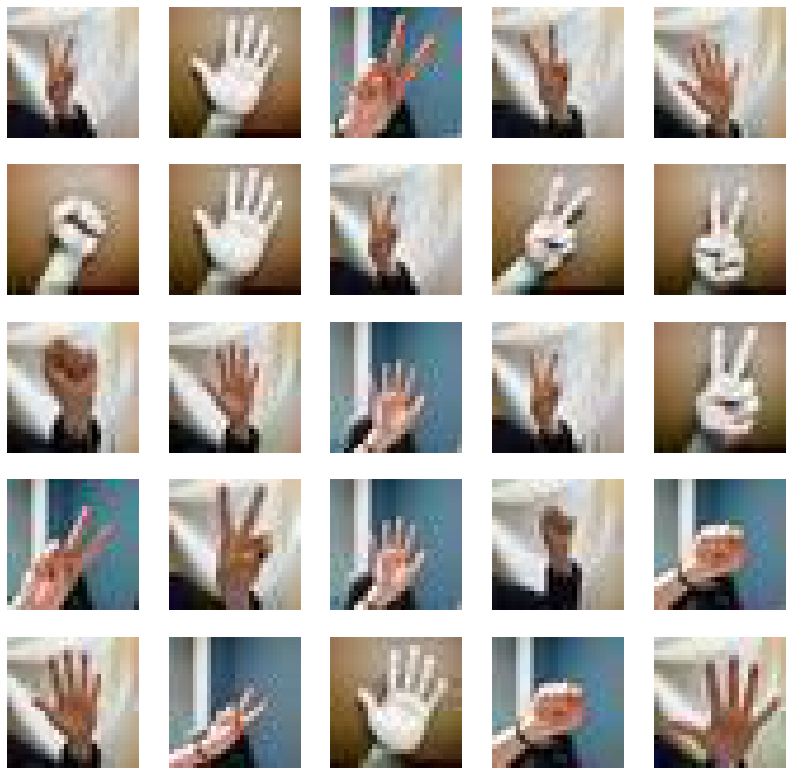

In [35]:
# 데이터셋 출력
plt.figure(figsize=(14, 14))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.imshow(x_train[i], 'gray')
    plt.axis('off')
plt.show()

- 슬, 승순, 승환 데이터들이 적절하게 섞여있다!
- 이 데이터 셋으로 다시 모델학습을 진행한다

### 모델학습
- 일단 위에서 진행했던 훈련과 동일하게 훈련을 진행한다

In [36]:
# model
'''
convolution layer 
- kernel_size : 3,3

maxpooling
- kernel_size : 2,2

activation function : relu
final activation function : softmax
optimizer : adam
loss : 교차 엔트로피오차 함수
'''
model = keras.models.Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3))) # image feature
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu')) # image feature
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu')) # 분류기 알고리즘 복잡도
model.add(Dense(3, activation='softmax')) # 최종 분류기 class 수

In [37]:
# model 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [38]:
# train
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 검증데이터를 25%비율로 잡고 학습한다
model.fit(x_train, y_train, epochs=20, validation_split=0.25)

Epoch 1/20
17/17 [==============================] - 1s 36ms/step - loss: 1.0819 - accuracy: 0.3981 - val_loss: 1.0410 - val_accuracy: 0.4722
Epoch 2/20
17/17 [==============================] - 0s 26ms/step - loss: 0.9679 - accuracy: 0.6296 - val_loss: 0.9581 - val_accuracy: 0.4833
Epoch 3/20
17/17 [==============================] - 0s 26ms/step - loss: 0.8148 - accuracy: 0.7130 - val_loss: 0.7843 - val_accuracy: 0.6889
Epoch 4/20
17/17 [==============================] - 0s 25ms/step - loss: 0.6034 - accuracy: 0.8352 - val_loss: 0.5704 - val_accuracy: 0.8000
Epoch 5/20
17/17 [==============================] - 0s 27ms/step - loss: 0.4344 - accuracy: 0.8833 - val_loss: 0.4250 - val_accuracy: 0.8222
Epoch 6/20
17/17 [==============================] - 0s 29ms/step - loss: 0.2838 - accuracy: 0.9296 - val_loss: 0.2600 - val_accuracy: 0.9556
Epoch 7/20
17/17 [==============================] - 1s 32ms/step - loss: 0.1813 - accuracy: 0.9667 - val_loss: 0.1725 - val_accuracy: 0.9722
Epoch 8/20
17

- 에포크가 완료되기전에 이미 train 정확도와 validation 정확도가 1이 나오는 지점이 보인다. 조기종료 기능을 넣어봐야겠다
- 과적합을 의심해보기엔 검증 데이터 정확도도 무지 높아서 과적합은 아닌거같다..!
---
### Test accuracy 확인

In [39]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

6/6 - 0s - loss: 0.0154 - accuracy: 0.9889
test_loss: 0.015384729951620102 
test_accuracy: 0.9888888597488403


In [42]:
# 제대로 테스트 검증이 되었는지 출력해서 확인
# model.predict() 확인
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=123  #123번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [1.4377912e-04 9.9977165e-01 8.4562089e-05]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


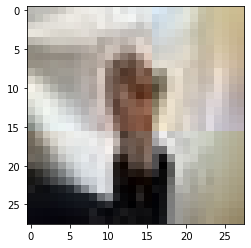

In [43]:
# 실제 정답과 확인
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

- 테스트 정확도도 98%로 꽤 높은 수치가 나온다..!
- 새로운 데이터를 테스트 데이터로 변환해서 다시 테스트 정확도를 확인해본다

### Test accuracy - 2
- 채림님의 데이터를 활용할 예정
    - 핸드폰으로 직접 찍은 사진이라고 하셔서 새로운 결과값이 나오지 않을까 기대해본다


In [47]:
# resizing data
# 채림님 데이터
image_dir_path_s = os.getenv("HOME") + "/aiffel/cha_data/scissor"
image_dir_path_r = os.getenv("HOME") + "/aiffel/cha_data/rock"
image_dir_path_p = os.getenv("HOME") + "/aiffel/cha_data/paper"
resize_images(image_dir_path_s)
resize_images(image_dir_path_r)
resize_images(image_dir_path_p)

# split data to test
image_dir_path = os.getenv("HOME") + "/aiffel/cha_data"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [48]:
# 채림님 데이터로 테스트 정확도 확인
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.0027 - accuracy: 1.0000
test_loss: 0.0027234540320932865 
test_accuracy: 1.0


In [49]:
# 제대로 테스트 검증이 되었는지 출력해서 확인
# model.predict() 확인
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=123  #123번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0. 1. 0.]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


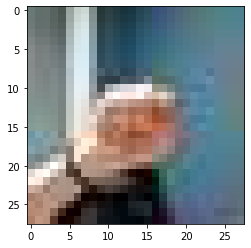

In [50]:
# 실제 정답과 확인
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

- 여전히 뭔가가 이상하다. 데이터셋을 더 많이 가져와서 다시 학습을 진행해봐야겠다.

---
## 새로운 데이터셋 만들기-2
- 7명 그루의 데이터셋을 추가

In [66]:
# 경로를 바꿔가면서 학습데이터 생성
# 데이터 리사이즈
paths = ["/aiffel/ss_data", "/aiffel/rock_scissor_paper", "/aiffel/sh_data",
        "/aiffel/add_data_1", "/aiffel/add_data_2", "/aiffel/add_data_3", "/aiffel/add_data_4"]

# 데이터 리사이즈
for path in paths:
    image_dir_path_s = os.getenv("HOME") + path + "/scissor"
    image_dir_path_r = os.getenv("HOME") + path + "/rock"
    image_dir_path_p = os.getenv("HOME") + path + "/paper"
    resize_images(image_dir_path_s)
    resize_images(image_dir_path_r)
    resize_images(image_dir_path_p)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images r

In [67]:
# 전체 데이터 담을 빈 array
total_x_train = np.array([], dtype=np.int32).reshape(0, 28, 28, 3)
total_y_train = np.array([], dtype=np.int32)

for i, path in enumerate(paths):
    image_dir_path = os.getenv("HOME") + path
    (x_train_i, y_train_i) = load_data(image_dir_path)
    
    # 이미지 합치기 - concatenate
    total_x_train = np.concatenate((total_x_train, x_train_i), axis=0)
    total_y_train = np.concatenate((total_y_train, y_train_i), axis=0)

print(total_x_train.shape, total_y_train.shape)

학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.
(2100, 28, 28, 3) (2100,)


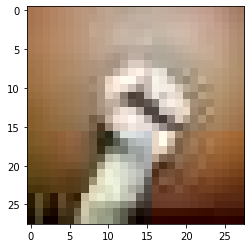

In [68]:
# 랜덤 이미지 출력
plt.imshow(total_x_train[100],cmap=plt.cm.binary)
plt.show()

In [69]:
# 이미지 값 정규화
x_train_norm = total_x_train / 255.0   # 입력은 0~1 사이의 값으로 정규화

In [70]:
# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_train_norm, total_y_train,
                                                    test_size=0.2, random_state=42, shuffle=True)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1680, 28, 28, 3) (420, 28, 28, 3) (1680,) (420,)


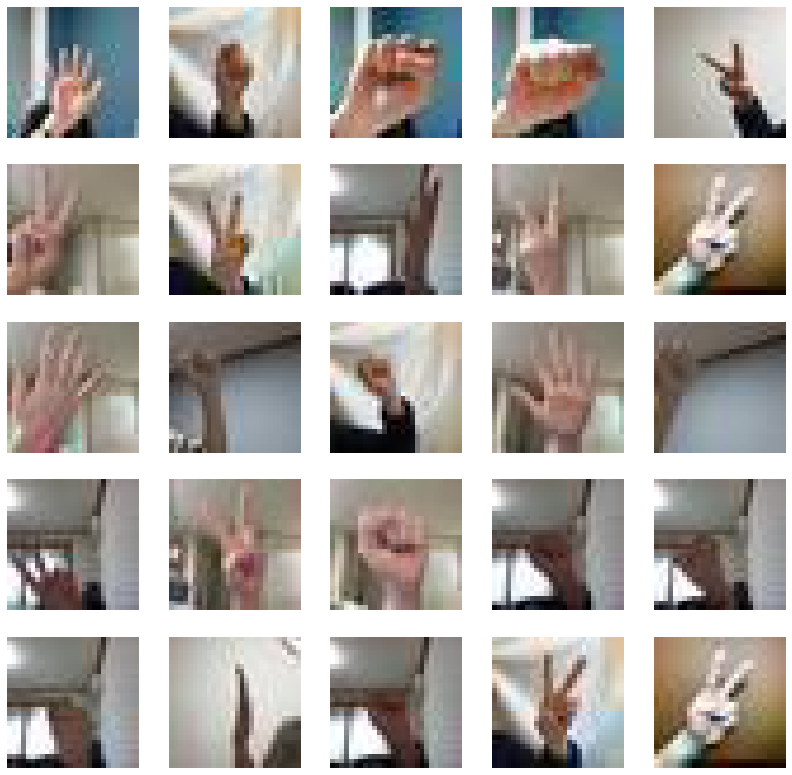

In [71]:
# 이미지 적절히 섞였는지 확인 - 데이터셋 출력
plt.figure(figsize=(14, 14))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.imshow(x_train[i], 'gray')
    plt.axis('off')
plt.show()

In [74]:
# 추가 모듈 임포트
from keras.layers import BatchNormalization, Dropout

# model
'''
convolution layer 
- kernel_size : 3,3

maxpooling
- kernel_size : 2,2

activation function : relu
    - he initialize 사용
    
final activation function : softmax

optimizer : adam

loss : 교차 엔트로피오차 함수

dropout : 과적합 방지
'''
model = keras.models.Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3))) # image feature
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu')) # image feature
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32, kernel_initializer='he_normal', activation='relu')) # 분류기 알고리즘 복잡도
model.add(Dropout(rate=0.3))
model.add(Dense(3, activation='softmax')) # 최종 분류기 class 수

# 모델 출력
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                25632     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

In [76]:
# train
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_split=0.25)

Epoch 1/20
40/40 [==============================] - 1s 26ms/step - loss: 1.0921 - accuracy: 0.3714 - val_loss: 1.0809 - val_accuracy: 0.4381
Epoch 2/20
40/40 [==============================] - 1s 27ms/step - loss: 1.0711 - accuracy: 0.4103 - val_loss: 1.0334 - val_accuracy: 0.5714
Epoch 3/20
40/40 [==============================] - 1s 23ms/step - loss: 1.0105 - accuracy: 0.4873 - val_loss: 0.9226 - val_accuracy: 0.6262
Epoch 4/20
40/40 [==============================] - 1s 23ms/step - loss: 0.8661 - accuracy: 0.6087 - val_loss: 0.7527 - val_accuracy: 0.7524
Epoch 5/20
40/40 [==============================] - 1s 23ms/step - loss: 0.7337 - accuracy: 0.6690 - val_loss: 0.6474 - val_accuracy: 0.8190
Epoch 6/20
40/40 [==============================] - 1s 23ms/step - loss: 0.6265 - accuracy: 0.7484 - val_loss: 0.4981 - val_accuracy: 0.8714
Epoch 7/20
40/40 [==============================] - 1s 23ms/step - loss: 0.5268 - accuracy: 0.7897 - val_loss: 0.4101 - val_accuracy: 0.8548
Epoch 8/20
40

- early stopping 을 추가해서 다시 훈련

In [77]:
# 조기종료 세팅
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

In [78]:
history = model.fit(x_train, y_train, epochs=20, callbacks=[early_stop], validation_split=0.25)

Epoch 1/20
40/40 [==============================] - 1s 24ms/step - loss: 0.2093 - accuracy: 0.9119 - val_loss: 0.0989 - val_accuracy: 0.9667
Epoch 2/20
40/40 [==============================] - 1s 23ms/step - loss: 0.1487 - accuracy: 0.9452 - val_loss: 0.0868 - val_accuracy: 0.9714
Epoch 3/20
40/40 [==============================] - 1s 23ms/step - loss: 0.1467 - accuracy: 0.9421 - val_loss: 0.0830 - val_accuracy: 0.9690
Epoch 4/20
40/40 [==============================] - 1s 23ms/step - loss: 0.1444 - accuracy: 0.9444 - val_loss: 0.0709 - val_accuracy: 0.9738
Epoch 5/20
40/40 [==============================] - 1s 23ms/step - loss: 0.1429 - accuracy: 0.9397 - val_loss: 0.0736 - val_accuracy: 0.9714
Epoch 6/20
40/40 [==============================] - 1s 26ms/step - loss: 0.1441 - accuracy: 0.9437 - val_loss: 0.0732 - val_accuracy: 0.9738


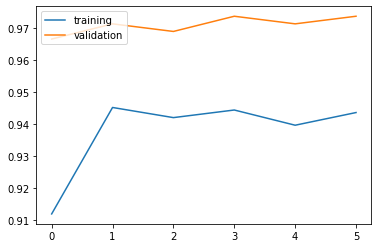

In [80]:
# 그래프로 학습결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

- 상당히 이상한 그래프가 나온다...! 훈련정확도보다 검증정확도가 더 높다...?

In [83]:
# 학습결과 최종 확인
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

14/14 [==============================] - 0s 7ms/step - loss: 0.0652 - accuracy: 0.9881
Test accuracy:  0.988095223903656


- 상당히 과적합 되어있다..ㅠㅠ
- 배치정규화를 추가하고, 가중치 초기값 he initialize, stride, padding 값 등을 설정해서 훈련해본다

In [88]:
from keras.layers import Activation

# model
'''
convolution layer 
- kernel_size : 3,3

maxpooling
- kernel_size : 2,2

activation function : relu
    - he initialize 사용
    
final activation function : softmax

optimizer : adam

loss : 교차 엔트로피오차 함수

dropout : 과적합 방지
'''
model = keras.models.Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3), 
                 strides=(1,1), padding='same', kernel_initializer='he_normal')) # image feature
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3),
                strides=(1,1), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32, kernel_initializer='he_normal', activation='relu')) # 분류기 알고리즘 복잡도
model.add(Dropout(rate=0.3))
model.add(Dense(3, kernel_initializer='he_normal', activation='softmax')) # 최종 분류기 class 수

# 모델 출력
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 32)       

In [95]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs=20, callbacks=[early_stop], validation_split=0.25)

Epoch 1/20
40/40 [==============================] - 3s 51ms/step - loss: 0.8900 - accuracy: 0.6357 - val_loss: 1.4636 - val_accuracy: 0.3357
Epoch 2/20
40/40 [==============================] - 2s 47ms/step - loss: 0.3983 - accuracy: 0.8413 - val_loss: 0.9309 - val_accuracy: 0.5167
Epoch 3/20
40/40 [==============================] - 2s 55ms/step - loss: 0.2177 - accuracy: 0.9214 - val_loss: 0.7181 - val_accuracy: 0.8214
Epoch 4/20
40/40 [==============================] - 2s 46ms/step - loss: 0.1450 - accuracy: 0.9500 - val_loss: 0.5843 - val_accuracy: 0.8381
Epoch 5/20
40/40 [==============================] - 2s 45ms/step - loss: 0.1014 - accuracy: 0.9675 - val_loss: 0.4983 - val_accuracy: 0.8810
Epoch 6/20
40/40 [==============================] - 2s 45ms/step - loss: 0.0668 - accuracy: 0.9810 - val_loss: 0.3638 - val_accuracy: 0.9000
Epoch 7/20
40/40 [==============================] - 2s 45ms/step - loss: 0.0595 - accuracy: 0.9794 - val_loss: 0.2816 - val_accuracy: 0.9333
Epoch 8/20
40

- 상당한 과적합같다
- 데이터 양이 많지 않아서 그런것같다..! 
- 모델 층을 조금 손보고, 학습횟수를 줄여봐야겠다.

In [100]:
model = keras.models.Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3), 
                 strides=(1,1), padding='same', kernel_initializer='he_normal')) # image feature
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3),
                strides=(1,1), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32, kernel_initializer='he_normal', activation='relu')) # 분류기 알고리즘 복잡도
model.add(Dropout(rate=0.3))
model.add(Dense(3, kernel_initializer='he_normal', activation='softmax')) # 최종 분류기 class 수

# 모델 출력
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 32)        

In [101]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# 조기종료 한번더 세팅
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10, callbacks=[early_stop], validation_split=0.25)

Epoch 1/10
40/40 [==============================] - 2s 41ms/step - loss: 0.8271 - accuracy: 0.6254 - val_loss: 1.0442 - val_accuracy: 0.3976
Epoch 2/10
40/40 [==============================] - 1s 36ms/step - loss: 0.3625 - accuracy: 0.8611 - val_loss: 0.9438 - val_accuracy: 0.5905
Epoch 3/10
40/40 [==============================] - 1s 37ms/step - loss: 0.2137 - accuracy: 0.9286 - val_loss: 0.8126 - val_accuracy: 0.6976
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.1267 - accuracy: 0.9579 - val_loss: 0.6596 - val_accuracy: 0.9429
Epoch 5/10
40/40 [==============================] - 1s 37ms/step - loss: 0.0939 - accuracy: 0.9722 - val_loss: 0.5420 - val_accuracy: 0.9452
Epoch 6/10
40/40 [==============================] - 1s 37ms/step - loss: 0.0640 - accuracy: 0.9849 - val_loss: 0.3695 - val_accuracy: 0.9952
Epoch 7/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0478 - accuracy: 0.9881 - val_loss: 0.2355 - val_accuracy: 0.9881
Epoch 8/10
40

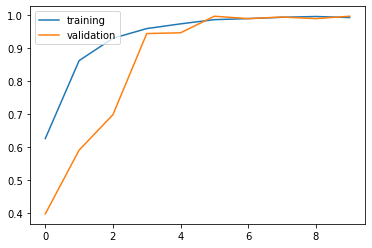

In [102]:
# 그래프로 학습결과 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [103]:
# 학습결과 최종 확인
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

14/14 [==============================] - 0s 8ms/step - loss: 0.0618 - accuracy: 0.9952
Test accuracy:  0.9952380657196045


- 와! 드디어 책에서 보던 그래프가 나왔다! 이상하던 과적합은 해결이 된걸까...? 
- 정확도가 99%가 나온게 조금 이상한것같기도하지만 오히려 1이 아니라서 안심이 되기도 하다!

---
# 회고

[KEEP]   
- 낯선 코드를 봤을때 꽤 코드 흐름을 읽어낼수 있었다는게 신기하다. load_data함수와 resize함수를 보면서 어떤 방식으로 흘러가는지 확인했고, 이후에 for 반복문으로 여러 데이터셋을 합칠때 참고해서 코드를 만들수 있었다.
- 문제상황이 발생(과적합)했을때 공부했던 오버피팅 방지를 위한 여러 시도를 해보았다. 내가 만든 모델로 학습을 시키고, 학습결과를 그래프로 그려보고, 수정을 해보는 전체의 과정이 즐겁고 신기하고, 앞으로 더 깊이 꼼꼼하게 공부해볼 힘을 받게된 계기가 되었다.

[PROBLEM]
- 정확도가 1이 나오고, 훈련정확도보다 검증정확도가 높게 나오는 이상한 상황이 발생했다. 
- 데이터가 부족하다고만 생각해서 데이터를 업로드하기로 결정후 lms에 데이터셋들을 다운받아서 업로드하는데 이 과정에서 꽤 시간을 많이 지체했다.

[TRY]
- 문제가 발생했을때 한걸음 뒤로 물러나서 어떤 상황인지 다시 정리하고 문제해결을 해보는 습관을 가져봐야겠다. 당황하고 마음이 급해지니 효율적이지않은 방식인데도 계속 그 방식을 고집하고, 많은 시간을 낭비했다.
- kaggle에서 cnn관련 필사를 해보면서 다른 사람들은 데이터셋을 어떻게 해석하고, 모델을 만드는지 공부해봐야겠다.